### **RL Assignment:** _MiniHack the Planet (DQN)_

**Group Members:**

- 473561    (Thato Mahlatji)
- 712019    (Shivaan Govender)
- 1056862   (Alexandra Barry)
- 1821334   (Kayleize Govender)

In [1]:
import gym
import cv2
import random
import numpy as np
from gym import spaces
from collections import deque
import matplotlib.pyplot as plt 

In [2]:
import minihack
from nle import nethack

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cv2.ocl.setUseOpenCL(False)

In [4]:
from torch.nn import (BatchNorm2d, Conv2d, CrossEntropyLoss, Dropout, Linear,
                      MaxPool2d, Module, ReLU, Sequential, Softmax)

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
print("Using", device, "device")

GPU available
Using cuda device


## Helper Functions

In [6]:
def display_screen(state):
    """Displays the state as the screen in image form using the 'pixel' observation key"""
    img = state['pixel']
    plt.imshow(img)

In [7]:
def format_state(state):
    """Formats state into a form that the NN can accept"""
    glyphs = state["glyphs"]
    chars = state["chars"]

    # Normalize glyphs
    glyphs = glyphs / glyphs.max()
    #convert to torch tensors to be used by the NN
    glyphs=torch.from_numpy(glyphs)
    chars=torch.from_numpy(chars)
    state_tensor = torch.stack((glyphs, chars), dim=0)
    state_formatted = torch.tensor(np.expand_dims(state_tensor, axis=0))
    return state_formatted.squeeze(0)

## DQN Model

The implemented DQN is based on the rail lab implementation which can be found here: https://github.com/raillab/dqn.

In [8]:
class ReplayBuffer:
    """
    Simple storage for transitions from an environment.
    """

    def __init__(self, size):
        """
        Initialise a buffer of a given size for storing transitions
        :param size: the maximum number of transitions that can be stored
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, state, action, reward, next_state, done):
        """
        Add a transition to the buffer. Old transitions will be overwritten if the buffer is full.
        :param state: the agent's initial state
        :param action: the action taken by the agent
        :param reward: the reward the agent received
        :param next_state: the subsequent state
        :param done: whether the episode terminated
        """
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, indices):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in indices:
            data = self._storage[i]
            state, action, reward, next_state, done = data
            states.append(np.array(state, copy=False))
            actions.append(action)
            rewards.append(reward)
            next_states.append(np.array(next_state, copy=False))
            dones.append(done)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions from the buffer.
        :param batch_size: the number of transitions to sample
        :return: a mini-batch of sampled transitions
        """
        indices = np.random.randint(0, len(self._storage) - 1, size=batch_size)
        return self._encode_sample(indices)

Neural Network Architecture

In [9]:
class DQN(nn.Module):
    def __init__(self, action_space: spaces.Discrete):
        super().__init__()

        # Convolutional layers taking in two states (glyphs and chars)
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, padding='same'),  # Convolution layer with 32 filters and 3x3 kernel
            nn.BatchNorm2d(32),  # Batch normalization to stabilize training
            nn.ReLU(),  # ReLU activation function
            nn.MaxPool2d(3, padding=(0, 1)),  # Max-pooling layer with 3x3 window
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(),  # ReLU activation
            nn.MaxPool2d(3, padding=(1, 0))  # Max-pooling with padding
        )

        # Fully connected layers for prediction
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # Flatten the output from convolutional layers
            nn.Linear(3 * 9 * 64, 512),  # Fully connected layer with 512 neurons
            nn.ReLU(),  # ReLU activation
            nn.Linear(512, 256),  # Fully connected layer with 256 neurons
            nn.ReLU(),  # ReLU activation
            nn.Linear(256, 128),  # Fully connected layer with 128 neurons
            nn.ReLU()  # ReLU activation
        )

        # Output layer for action values
        self.output_layer = nn.Linear(128, action_space.n)  # Fully connected layer for action space size

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.conv1(x.float())

        # Pass the output through fully connected layers
        x = self.fc_layers(x)

        # Compute action values
        logits = self.output_layer(x)
        return logits

In [10]:
# Define class that brings all the DQN compenents together so that a model can be trained
class DQNAgent():

    def __init__(
        self,
        observation_space, #: spaces.Box,
        action_space : spaces.Discrete,
        replay_buffer: ReplayBuffer,
        use_double_dqn,
        lr,
        batch_size,
        gamma,
    ):
        """
        Initialise the DQN algorithm using the Adam optimiser
        :param action_space: the action space of the environment
        :param observation_space: the state space of the environment
        :param replay_buffer: storage for experience replay
        :param lr: the learning rate for Adam
        :param batch_size: the batch size
        :param gamma: the discount factor
        """
        global device
        self.action_space = action_space

        # TODO: Initialise agent's networks, optimiser and replay buffer
        self.policy_network = DQN(action_space).to(device)
        self.target_network = DQN(action_space).to(device)
        self.update_target_network()
        self.target_network.eval()

        #print(self.policy_network)

        self.replay_buffer = replay_buffer
        self.use_double_dqn = use_double_dqn
        self.lr = lr
        self.batch_size = batch_size
        self.gamma = gamma

        self.optimizer = torch.optim.Adam(self.policy_network.parameters(lr), lr=self.lr)
        #self.update_target_network()


    def optimise_td_loss(self):
        """
        Optimise the TD-error over a single minibatch of transitions
        :return: the loss
        """
        states, actions, rewards, next_states, done = self.replay_buffer.sample(self.batch_size)

        states = torch.tensor(states).float().to(device)
        actions = torch.tensor(actions).long().to(device)
        rewards = torch.tensor(rewards).float().to(device)
        next_states = torch.tensor(next_states).float().to(device)
        done = torch.ByteTensor(done).to(device)

        with torch.no_grad():
            if self.use_double_dqn:
                _, max_next_action = self.policy_network(next_states).max(1)
                max_next_q_values = self.target_network(next_states).gather(1, max_next_action.unsqueeze(1)).squeeze()
            else:
                next_q_values = self.target_network(next_states)
                max_next_q_values, _ = next_q_values.max(1)
            target_q_values = rewards + (1 - done) * self.gamma * max_next_q_values

        input_q_values = self.policy_network(states)
        input_q_values = input_q_values.gather(1, actions.unsqueeze(1)).squeeze()

        loss = F.smooth_l1_loss(input_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def update_target_network(self):
        """
        Update the target Q-network by copying the weights from the current Q-network
        """
        self.target_network.load_state_dict(self.policy_network.state_dict())


    def act(self, state):
        """
        Select an action greedily from the Q-network given the state
        :param state: the current state
        :return: the action to take
        """
        # TODO Select action greedily from the Q-network given the state
        # Note: Neural networks in PyTorch require input data to be in the form of tensors. (use unsqueeze)

        if not torch.cuda.is_available():
            # If not GPU, eg. Running on CPU
            state_ = state.type(torch.FloatTensor)
        else:
            # If runnning on GPU
            state_ = state.type(torch.cuda.FloatTensor)

        state_ = torch.unsqueeze(state_, 0).to(device)
        q_val = self.policy_network(state_)
        q_val = q_val.to('cpu').detach().numpy()
        action = np.argmax(q_val)
        return action


## DQN Method

Train the Agent using the DQN Model : Combined methods from the DQN lab and the Rail Lab Repo: https://github.com/raillab/dqn/blob/master/train_atari.py

In [11]:
def train_dqn(env,model_save_path, max_episodes=1000, verbose=True):   
    
    
    hyper_params = {
        "replay-buffer-size": int(5e3),  # replay buffer size
        "learning-rate": 1e-4,  # learning rate for Adam optimizer
        "discount-factor": 0.99, # discount factor
        "num-steps": int(5e5), # total number of steps to run the environment for
        "batch-size": 256, #32, # number of transitions to optimize at the same time
        "learning-starts": 3000, # number of steps before learning starts
        "learning-freq": 3,  # number of iterations between every optimization step
        "use-double-dqn": True,  # use double deep Q-learning
        "target-update-freq": 1000,  # number of iterations between every target network update
        "eps-start": 1.0,  # e-greedy start threshold
        "eps-end": 0.01, # e-greedy end threshold
        "eps-fraction": 0.1,  # fraction of num-steps
        "print-freq": 10,
        "gamma": 0.999
    }

    #Seed To Ensure Reproducible Code
    seed = np.random.randint(1000000)
    np.random.seed(seed)
    env.seed(seed)

    # Create DQN agent
    replay_buffer = ReplayBuffer(hyper_params['replay-buffer-size'])
    agent = DQNAgent(
        env.observation_space,
        env.action_space,
        replay_buffer=replay_buffer,
        use_double_dqn=hyper_params['use-double-dqn'],
        lr=hyper_params['learning-rate'],
        batch_size=hyper_params['batch-size'],
        gamma=hyper_params['gamma'],
    )

    # define variables to track agent metrics

    # define variables
    scores = [0]
    mean_rewards = [0.0]

    # Reset gym env before training
    state = format_state(env.reset())
    eps_timesteps = hyper_params['eps-fraction'] * float(hyper_params['num-steps'])
    # Train for set number of steps
    for t in range(hyper_params['num-steps']):
        total_reward = 0.0
        # determine exploration probability
        fract = min(1.0, float(t) / eps_timesteps)
        eps_threshold = hyper_params["eps-start"] + fract * (hyper_params["eps-end"] - hyper_params["eps-start"])
        
        #epsilon greedy policy
        sample = random.random()
        
        # Decide to explore and choose random action or use model to act
        if sample < eps_threshold:
            action = np.random.choice(agent.action_space.n)
        
        # Else use policy network to obtain action
        else:
            action = agent.act(state)

        # Take step in environment
        (next_state, reward, done, _) = env.step(action)
        
        # Augment Input
        next_state = format_state(next_state)
        
        #Shape reward
        if reward==-0.01:
            reward=-1
        elif reward==0:
            reward=0.5
        elif reward==1:
            reward=2
        
        # add state, action, shaped-reward, next_state, done to reply buffer - cast done to float
        replay_buffer.add(state, action, reward, next_state, float(done))
        
        #sum rewards for each episode
        total_reward += reward
        state = next_state
        if done:
            scores.append(total_reward)
            print(f"episode reward: {total_reward}")
            seed = np.random.randint(1000000)
            np.random.seed(seed)
            env.seed(seed)
            state = format_state(env.reset())

        if t > hyper_params['learning-starts'] and t % hyper_params['learning-freq'] == 0:
            ans = agent.optimise_td_loss()

        if t > hyper_params['learning-starts'] and t % hyper_params['target-update-freq'] == 0:
            agent.update_target_network()

        num_episodes = len(scores)
        if done and hyper_params['print-freq'] is not None and len(scores) % hyper_params['print-freq'] == 0:
            mean_100ep_reward = round(np.mean(scores[-101:-1]), 1)
            mean_rewards.append(mean_100ep_reward)
            print('********************************************************')
            print('steps: {}'.format(t))
            print('episodes: {}'.format(num_episodes))
            print('mean 100 episode reward: {}'.format(mean_100ep_reward))
            print('% time spent exploring: {}'.format(eps_threshold))
            print('********************************************************')


        torch.save(agent.policy_network.state_dict(), model_save_path)
        
        if num_episodes >=max_episodes:
            return scores,mean_rewards
        
    return scores,mean_rewards

## Navigation - Room 5x5 
Training model on Room 5x5 environment

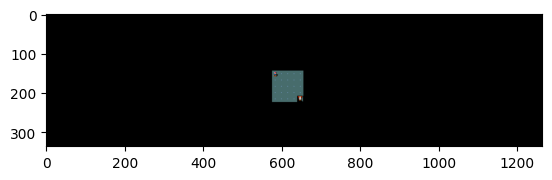

In [12]:
#Actions available for agent
MOVE_ACTIONS = tuple(nethack.CompassDirection)
env = gym.make("MiniHack-Room-5x5-v0", observation_keys=["glyphs","pixel","message","chars"], actions=MOVE_ACTIONS)
# Display the screen of the starting state 
display_screen(env.reset())

In [13]:
scores = train_dqn(env=env,model_save_path="MiniHack-Room-5x5-v0.pth",verbose=True)

episode reward: 0.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 0.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: -0.01
episode reward: 0.0
********************************************************
steps: 719
episodes: 10
mean 100 episode reward: 0.7
% time spent exploring: 0.9857638
********************************************************
episode reward: 1.0
episode reward: 0.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: -0.01
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 1211
episodes: 20
mean 100 episode reward: 0.7
% time spent exploring: 0.9760222
********************************************************
episode reward: 0.0
episode reward: -0.01
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode rew

episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 9405
episodes: 210
mean 100 episode reward: 1.0
% time spent exploring: 0.813781
********************************************************
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 9722
episodes: 220
mean 100 episode reward: 1.0
% time spent exploring: 0.8075044
********************************************************
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 9886
episodes: 230
mean 100 episode reward: 1.0
% time spent exploring: 0.8042572
*********

episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 14080
episodes: 420
mean 100 episode reward: 1.0
% time spent exploring: 0.721216
********************************************************
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 14302
episodes: 430
mean 100 episode reward: 1.0
% time spent exploring: 0.7168204
********************************************************
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode rewar

episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 17188
episodes: 620
mean 100 episode reward: 1.0
% time spent exploring: 0.6596776
********************************************************
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 17322
episodes: 630
mean 100 episode reward: 1.0
% time spent exploring: 0.6570244
********************************************************
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 17476
episodes: 640
mean 100

episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 19893
episodes: 830
mean 100 episode reward: 1.0
% time spent exploring: 0.6061186000000001
********************************************************
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 20001
episodes: 840
mean 100 episode reward: 1.0
% time spent exploring: 0.6039802000000001
********************************************************
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward

In [14]:
len(scores[0])

1000

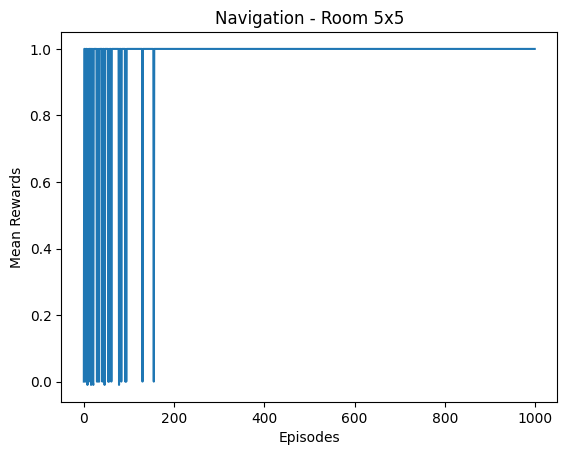

In [15]:
plt.figure(1)
plt.plot(scores[0])
plt.title("Navigation - Room 5x5")
plt.xlabel("Episodes")
plt.ylabel("Mean Rewards")
plt.savefig('Navigation-Room_5x5.png')
plt.show()

# Room 15x15

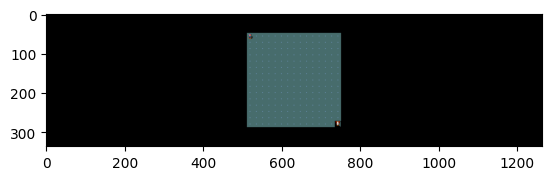

In [16]:
#Actions available for agent
MOVE_ACTIONS = tuple(nethack.CompassDirection)

env = gym.make("MiniHack-Room-15x15-v0", observation_keys=["glyphs","pixel","message","chars"], actions=MOVE_ACTIONS)
# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [17]:
scores_15x15 = train_dqn(env=env,model_save_path="MiniHack-Room-15x15-v0.pth",verbose=True)

episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 1.0
episode reward: 0.0
episode reward: 0.0
episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 2829
episodes: 10
mean 100 episode reward: 0.1
% time spent exploring: 0.9439858
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 1.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 5746
episodes: 20
mean 100 episode reward: 0.1
% time spent exploring: 0.8862292
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 1.0
episode rewa

episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 28891
episodes: 210
mean 100 episode reward: 1.0
% time spent exploring: 0.42795819999999996
********************************************************
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 29354
episodes: 220
mean 100 episode reward: 1.0
% time spent exploring: 0.4187907999999999
********************************************************
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
*****************************************************

episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 35405
episodes: 410
mean 100 episode reward: 1.0
% time spent exploring: 0.29898100000000005
********************************************************
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 35651
episodes: 420
mean 100 episode reward: 1.0
% time spent exploring: 0.2941102
********************************************************
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps

episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 39898
episodes: 610
mean 100 episode reward: 1.0
% time spent exploring: 0.21001959999999997
********************************************************
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 40105
episodes: 620
mean 100 episode reward: 1.0
% time spent exploring: 0.20592100000000002
********************************************************
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************

episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 43820
episodes: 810
mean 100 episode reward: 1.0
% time spent exploring: 0.13236400000000004
********************************************************
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
********************************************************
steps: 44010
episodes: 820
mean 100 episode reward: 1.0
% time spent exploring: 0.128602
********************************************************
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
episode reward: 1.0
***********************

In [18]:
len(scores_15x15[0])

1000

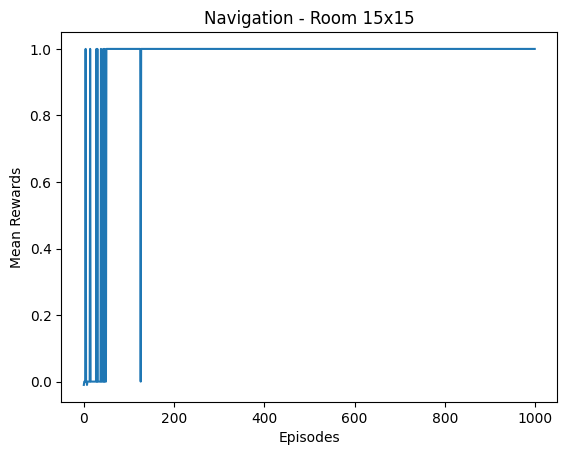

In [19]:
plt.figure(2)
plt.plot(scores_15x15[0])
plt.title("Navigation - Room 15x15")
plt.xlabel("Episodes")
plt.ylabel("Mean Rewards")
plt.savefig('Navigation-Room_15x15.png')
plt.show()

# MiniHack-LavaCross

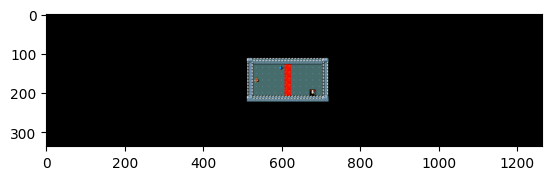

In [20]:
#Actions available for agent
MOVE_ACTIONS = tuple(nethack.CompassDirection)

MOVE_ACTIONS += (
            nethack.Command.PICKUP,
            nethack.Command.QUAFF,
            nethack.Command.FIRE,
        )

env = gym.make("MiniHack-LavaCross-Full-v0", observation_keys=["glyphs","pixel","message","chars"], actions=MOVE_ACTIONS)
# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [21]:
lava_scores = train_dqn(env=env,model_save_path="MiniHack-LavaCross-Full-v0.pth",verbose=True)

episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 391
episodes: 10
mean 100 episode reward: 0.0
% time spent exploring: 0.9922582
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 753
episodes: 20
mean 100 episode reward: 0.0
% time spent exploring: 0.9850906
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.

episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 10676
episodes: 210
mean 100 episode reward: 0.0
% time spent exploring: 0.7886152
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 11160
episodes: 220
mean 100 episode reward: 0.0
% time spent exploring: 0.779032
********************************************************
episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 12206
episodes: 230
mean 100 episode reward: 0.0
% time spent explo

episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 22564
episodes: 420
mean 100 episode reward: 0.0
% time spent exploring: 0.5532328
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 23033
episodes: 430
mean 100 episode reward: 0.0
% time spent exploring: 0.5439466
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode re

episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 33589
episodes: 620
mean 100 episode reward: -0.0
% time spent exploring: 0.33493779999999995
********************************************************
episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 33997
episodes: 630
mean 100 episode reward: -0.0
% time spent exploring: 0.3268594
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
**************************************

episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 48440
episodes: 820
mean 100 episode reward: -0.0
% time spent exploring: 0.040888000000000035
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 50177
episodes: 830
mean 100 episode reward: -0.0
% time spent exploring: 0.010000000000000009
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episod

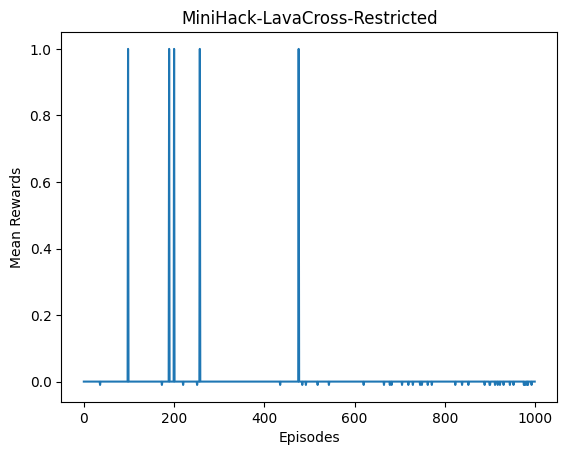

In [22]:
plt.figure(3)
plt.plot(lava_scores[0])
plt.title("MiniHack-LavaCross-Restricted")
plt.xlabel("Episodes")
plt.ylabel("Mean Rewards")
plt.savefig('MiniHack-LavaCross-Restricted.png')
plt.show()

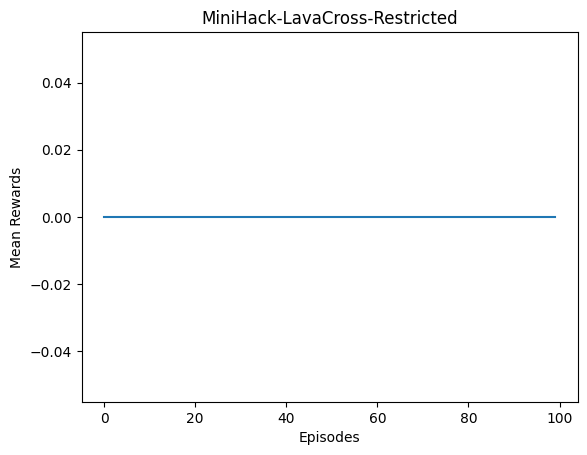

In [23]:
#plt.figure(3)
plt.plot(lava_scores[1])
plt.title("MiniHack-LavaCross-Restricted")
plt.xlabel("Episodes")
plt.ylabel("Mean Rewards")
#plt.savefig('MiniHack-LavaCross-Restricted.png')
plt.show()

## Skill Aquistion - Eat
Training model on Eat environment

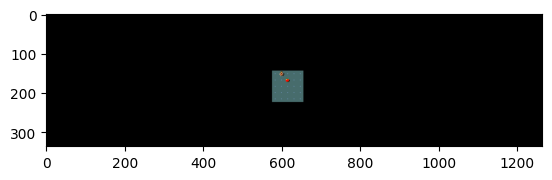

In [24]:
# Create the environment with the observations keys required as input to the DQN
MOVE_ACTIONS = tuple(nethack.CompassDirection)
MOVE_ACTIONS += (nethack.Command.EAT,)
MOVE_ACTIONS += (nethack.Command.PICKUP,)
env = gym.make("MiniHack-Eat-v0", observation_keys=["glyphs","pixel","message","chars"], actions=MOVE_ACTIONS)
# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [25]:
eat_scores = train_dqn(env=env,model_save_path="MiniHack-Eat-v0.pth",verbose=True)

episode reward: 0.0
episode reward: 0.0
episode reward: 1.0
episode reward: -0.01
episode reward: 0.0
episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
episode reward: 1.0
episode reward: 0.0
********************************************************
steps: 2452
episodes: 10
mean 100 episode reward: 0.2
% time spent exploring: 0.9514504
********************************************************
episode reward: -0.01
episode reward: 1.0
episode reward: 1.0
episode reward: -0.01
episode reward: -0.01
episode reward: -0.01
episode reward: -0.01
episode reward: -0.01
episode reward: 1.0
episode reward: -0.01
********************************************************
steps: 4432
episodes: 20
mean 100 episode reward: 0.3
% time spent exploring: 0.9122464
********************************************************
episode reward: 1.0
episode reward: 1.0
episode reward: -0.01
episode reward: 0.0
episode reward: -0.01
episode reward: 0.0
episode reward: -0.01
episode reward: -0.01
episode re

episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 49487
episodes: 210
mean 100 episode reward: 0.1
% time spent exploring: 0.020157400000000103
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: -0.01
episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
episode reward: -0.01
episode reward: 1.0
episode reward: 0.0
episode reward: -0.01
********************************************************
steps: 51855
episodes: 220
mean 100 episode reward: 0.1
% time spent exploring: 0.010000000000000009
********************************************************
episode reward: 0.0
episode reward: -0.01
episode reward: -0.01
episode reward: -0.01
episode reward: 0.0
episode reward: -0.01
episode reward: 0.0
episode reward

episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 99355
episodes: 410
mean 100 episode reward: -0.0
% time spent exploring: 0.010000000000000009
********************************************************
episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 101855
episodes: 420
mean 100 episode reward: -0.0
% time spent exploring: 0.010000000000000009
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
epi

episode reward: 0.0
********************************************************
steps: 146620
episodes: 600
mean 100 episode reward: 0.0
% time spent exploring: 0.010000000000000009
********************************************************
episode reward: 0.0
episode reward: -0.01
episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: -0.01
episode reward: 0.0
********************************************************
steps: 149120
episodes: 610
mean 100 episode reward: 0.0
% time spent exploring: 0.010000000000000009
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 151620
episodes: 620
mean 100 episode reward: 0.0
% time spent exploring: 0.01

episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 196620
episodes: 800
mean 100 episode reward: -0.0
% time spent exploring: 0.010000000000000009
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: -0.01
********************************************************
steps: 199120
episodes: 810
mean 100 episode reward: -0.0
% time spent exploring: 0.010000000000000009
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
ep

episode reward: -0.01
episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: -0.01
episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 246438
episodes: 1000
mean 100 episode reward: 0.0
% time spent exploring: 0.010000000000000009
********************************************************


In [26]:
len(eat_scores[0])

1000

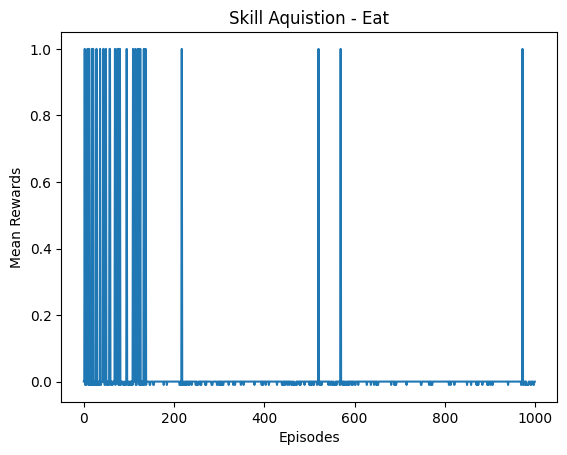

In [27]:
plt.figure(4)
plt.plot(eat_scores[0])
plt.title("Skill Aquistion - Eat")
plt.xlabel("Episodes")
plt.ylabel("Mean Rewards")
plt.savefig('SkillAquistion-Eat.png')
plt.show()

# Navigation - Quest Easy

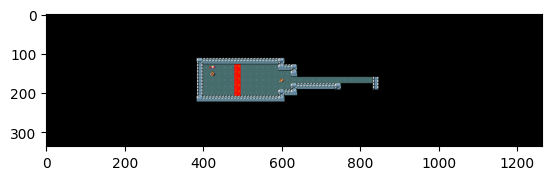

In [28]:
#Actions available for agent
MOVE_ACTIONS = tuple(nethack.CompassDirection)
#Actions available for agent
NAVIGATE_ACTIONS = MOVE_ACTIONS+(nethack.Command.PICKUP,nethack.Command.APPLY,nethack.Command.ZAP,nethack.Command.INVENTORY,nethack.Command.SEARCH,nethack.Command.FIRE,nethack.Command.FIGHT,nethack.Command.JUMP,nethack.Command.QUAFF,nethack.Command.WEAR,nethack.Command.RUSH,nethack.Command.PUTON)
#observation keys used to extract state information
env = gym.make("MiniHack-Quest-Easy-v0", observation_keys=["glyphs","pixel","message","chars"], actions=NAVIGATE_ACTIONS)
display_screen(env.reset())

In [29]:
quest_easy_scores = train_dqn(env=env,model_save_path="MiniHack-Quest-Easy-v0.pth",verbose=True)

episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 859
episodes: 10
mean 100 episode reward: 0.0
% time spent exploring: 0.9829918
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 1695
episodes: 20
mean 100 episode reward: 0.0
% time spent exploring: 0.966439
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.

episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 17169
episodes: 210
mean 100 episode reward: 0.0
% time spent exploring: 0.6600538
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 17882
episodes: 220
mean 100 episode reward: 0.0
% time spent exploring: 0.6459364
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 18836
episodes: 230
mean 100 episode reward: 0.0
% time spent explor

episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 40769
episodes: 410
mean 100 episode reward: -0.0
% time spent exploring: 0.1927738
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 42807
episodes: 420
mean 100 episode reward: -0.0
% time spent exploring: 0.15242140000000004
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 43948
episodes: 430
mean 100 episode reward: -0.0
% time spent exploring: 0.

/home/thato/anaconda3/envs/nle/lib/python3.8/site-packages/nle/env/base.py:602: UserWarning: Warning: smooth quitting of game failed, aborting.
  warnings.warn("Warning: smooth quitting of game failed, aborting.")


episode reward: -0.01
episode reward: -0.01
episode reward: -0.01
episode reward: 0.0
episode reward: -0.01
episode reward: 0.0
episode reward: -0.01
episode reward: -0.01
********************************************************
steps: 70396
episodes: 540
mean 100 episode reward: -0.0
% time spent exploring: 0.010000000000000009
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: -0.01
********************************************************
steps: 71893
episodes: 550
mean 100 episode reward: -0.0
% time spent exploring: 0.010000000000000009
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode rewa

episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 122415
episodes: 740
mean 100 episode reward: -0.0
% time spent exploring: 0.010000000000000009
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 122462
episodes: 750
mean 100 episode reward: -0.0
% time spent exploring: 0.010000000000000009
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
**************************

episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
********************************************************
steps: 139800
episodes: 940
mean 100 episode reward: -0.0
% time spent exploring: 0.010000000000000009
********************************************************
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: -0.01
episode reward: 0.0
episode reward: -0.01
episode reward: -0.01
episode reward: 0.0
episode reward: -0.01
********************************************************
steps: 142447
episodes: 950
mean 100 episode reward: -0.0
% time spent exploring: 0.010000000000000009
********************************************************
episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
episode reward

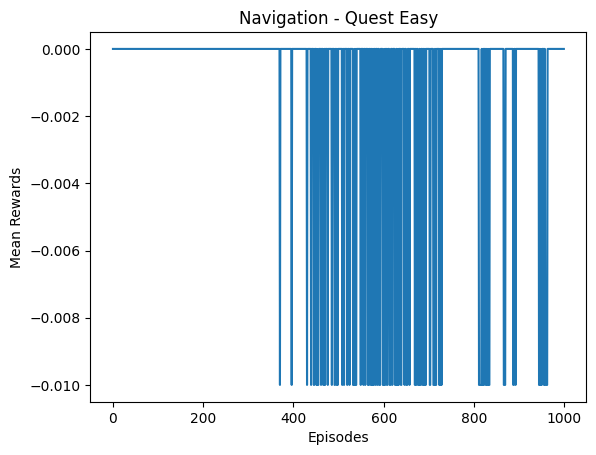

In [30]:
plt.figure(5)
plt.plot(quest_easy_scores[0])
plt.title("Navigation - Quest Easy")
plt.xlabel("Episodes")
plt.ylabel("Mean Rewards")
plt.savefig('Navigation-QuestEasy.png')
plt.show()

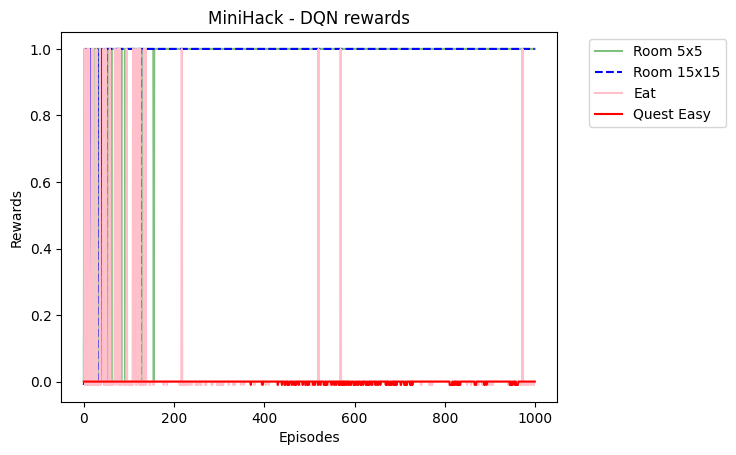

In [31]:
#plt.figure(figsize=(8,5))

#plt.plot(scores_random, alpha=0.5, color='blue', label=f'Room Random 5x5')

plt.plot(scores[0], alpha=0.5, color='green', label=f'Room 5x5')

plt.plot(scores_15x15[0], color='blue',linestyle = '--', label=f'Room 15x15')

plt.plot(eat_scores[0], color='pink', label=f'Eat')

plt.plot(quest_easy_scores[0], color='red', label=f'Quest Easy')




plt.title('MiniHack - DQN rewards')
plt.xlabel('Episodes')
plt.ylabel("Rewards")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.savefig('dqn_plots.png')
plt.show()


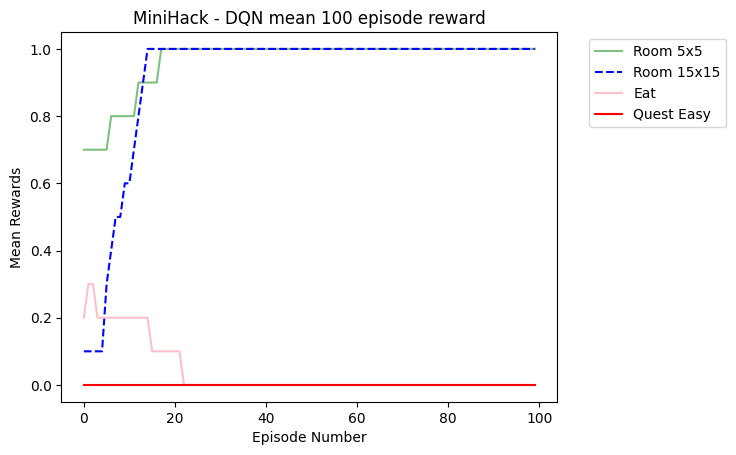

In [32]:
plt.plot(scores[1], alpha=0.5, color='green', label=f'Room 5x5')

plt.plot(scores_15x15[1], color='blue',linestyle = '--', label=f'Room 15x15')

plt.plot(eat_scores[1], color='pink', label=f'Eat')

plt.plot(quest_easy_scores[1], color='red', label=f'Quest Easy')




plt.title('MiniHack - DQN mean 100 episode reward')
plt.xlabel('Episode Number')
plt.ylabel("Mean Rewards")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.savefig('dqn_plots.png')
plt.show()


## Navigation - Quest Hard
Training model on Quest Hard environment

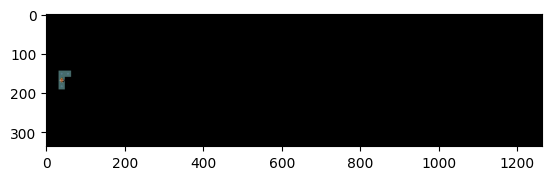

In [33]:
plt.figure(6)
# Create the environment with the observations keys required as input to the DQN
MOVE_ACTIONS = tuple(nethack.CompassDirection)
NAVIGATE_ACTIONS = MOVE_ACTIONS + (
    nethack.Command.PICKUP,
    nethack.Command.APPLY,
    nethack.Command.FIRE,
    nethack.Command.RUSH,
    nethack.Command.ZAP,
    nethack.Command.PUTON,
    nethack.Command.READ,
    nethack.Command.WEAR,
    nethack.Command.QUAFF,
    nethack.Command.PRAY,
    )
env = gym.make("MiniHack-Quest-Hard-v0", observation_keys=["glyphs","pixel","message","chars"], actions=MOVE_ACTIONS)
# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [34]:
quest_hard_scores = train_dqn(env=env,model_save_path="MiniHack-Quest-Hard-v0.pth",max_episodes=100,verbose=True)

episode reward: -0.01
episode reward: 0.0
episode reward: -0.01
episode reward: -0.01
episode reward: -0.01
episode reward: -0.01
episode reward: -0.01
episode reward: 0.0
episode reward: -0.01
episode reward: -0.01
********************************************************
steps: 9999
episodes: 10
mean 100 episode reward: -0.0
% time spent exploring: 0.8020198000000001
********************************************************
episode reward: -0.01
episode reward: -0.01
episode reward: 0.0
episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: -0.01
episode reward: -0.01
********************************************************
steps: 19999
episodes: 20
mean 100 episode reward: -0.0
% time spent exploring: 0.6040198
********************************************************
episode reward: -0.01
episode reward: 0.0
episode reward: -0.01
episode reward: 0.0
episode reward: 0.0
episode reward: 0.0
episode reward: -0.01
episode rewa

In [35]:
len(quest_hard_scores[0])

100

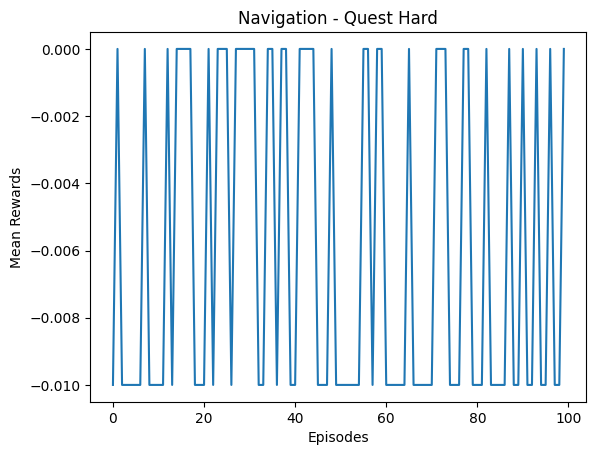

In [36]:
plt.figure(7)
plt.plot(quest_hard_scores[0])
plt.title("Navigation - Quest Hard")
plt.xlabel("Episodes")
plt.ylabel("Mean Rewards")
plt.savefig('Navigation-QuestHard.png')
plt.show()

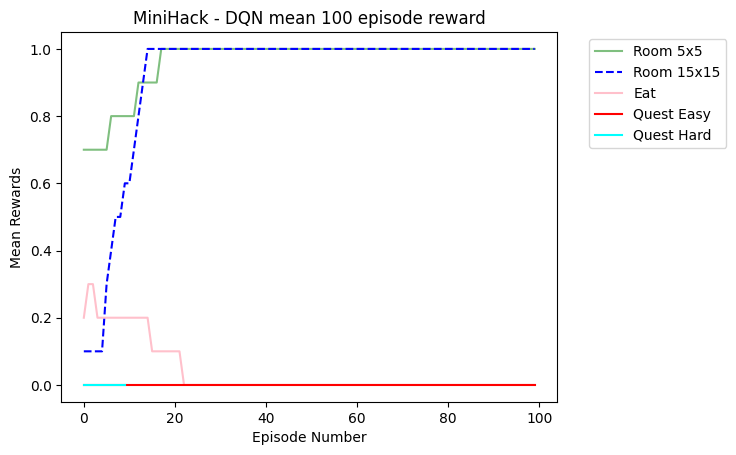

In [38]:
plt.plot(scores[1], alpha=0.5, color='green', label=f'Room 5x5')

plt.plot(scores_15x15[1], color='blue',linestyle = '--', label=f'Room 15x15')

plt.plot(eat_scores[1], color='pink', label=f'Eat')

plt.plot(quest_easy_scores[1], color='red', label=f'Quest Easy')

plt.plot(quest_hard_scores[1], color='cyan', label=f'Quest Hard')


plt.title('MiniHack - DQN mean 100 episode reward')
plt.xlabel('Episode Number')
plt.ylabel("Mean Rewards")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.savefig('dqn_plots.png')
plt.show()

In [37]:
print("----------END----------------") 

----------END----------------
